# Updates to how we do photometry calculations in `castor_etc`

Isaac Cheng - August 2023

This notebook is to accompany [pull request #10](https://github.com/CASTOR-telescope/ETC/pull/10)
overhauling the photometry calculations.

**This update fundamentally changes how we do photometry calculations in the backend.**

In short, we calculate the fraction of flux that is enclosed by a given aperture by
comparing it with the flux through an aperture that contains a known amount of flux from
the source.

To ensure the aperture is sufficiently well-sampled, we set the default value of a new
parameter,`supersample_factor`, to be 20, meaning every 1 pixel in the original aperture
will correspond to a block of 20 x 20 pixels in the supersampled array. Surprisingly, this
doesn't take much more time to run. As usual, the user can always choose a different
`supersample_factor`. After supersampling the aperture, we bin the aperture back down to
its correct dimensions. Note that we calculate the fraction of flux contained within the
user's aperture _before_ binning down.

Another benefit of supersampling the aperture is that it helps give detail to previously
unresolved sources. For example, high Sersic index galaxies (n=4 or greater) were
previously just 1 bright pixel in a sea of black pixels. By supersampling then
down-binning the arrays, we are able to see a more accurate representation of how the flux
would be distributed. That is, we are no longer assuming the flux at a pixel is just the
value at its centre, but rather it is the average of a set of neighbouring pixels\*.

\* Technically, our visualizations of the source show the average flux in a downbinned
pixel (i.e., the average of a block of supersampled pixels) relative to the flux at the
centre of the source. The visualization of this surface brightness profile should be the
same as what it would be in real life, however, except scaled by some constant (we always
use relative weights in our source visualizations).

Following are some details on the implementation for each type of source.


For point sources, we calculate the flux through a centred aperture that is at least 4.2
times the PSF's FWHM (which we set to be the telescope object's FWHM). The flux within
this aperture is considered to be all the flux from the source. Below, I will show some
comparisons of this encircled energy with the analytical result (known for a centred,
elliptical aperture) as well as the result from Monte Carlo integration. The latter two
estimates are more accurate, and we will always use these values over the supersampling
estimate for point sources.

For galaxies, we calculate the flux through a centred aperture that is the same size as
the galaxy's half-light radius and of the same orientation. The flux through such an
aperture is equal to half the flux emitted by the source.

For extended sources, we assume that all the flux is contained within the source's angular
extent, which is true for extended sources with a uniform surface brightness profile.
Thus, the signal that we get through a centred aperture of the same dimensions and
orientation as the extended source is treated as 100% of the flux.

**Important note:** when we implement PSF convolution for galaxies and extended sources,
we should compare the signal from a noiseless image/aperture to the signal through the
user's aperture after it has been convolved with the PSF (but before binning down). This
is because the half light radius of a galaxy and the dimensions of an angular source are
intrinsic characteristics that do not depend on the PSF, which is why we should use a
noiseless image as the reference signal.

With these changes, doing the signal-to-noise calculations is the _same_ for all sources.
By supersampling the array and comparing the flux through the user's aperture with a
reference aperture and flux, we obtain an "encircled energy" fraction just like we have
for point sources. Note that aperture area, the position and orientation of the source
within the aperture, etc. all still play a role in the photometry calculations because
these factors all affect the enclosed flux.

**_An enclosed flux fraction of 100% corresponds to the magnitude of the source that the
user set._** So if I normalize a spectrum to, say, an AB magnitude of 25, then this AB
magnitude will be the AB magnitude of the source if 100% of its flux was contained within
the aperture. If I choose an aperture that only contains 50% of the flux, however, the
effective AB magnitude will be dimmer. Again, the properties of a source are independent
of the aperture.

Following are some examples showing the updated photometry scheme.


In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

from castor_etc.background import Background
from castor_etc.photometry import Photometry
from castor_etc.sources import ExtendedSource, GalaxySource, PointSource
from castor_etc.telescope import Telescope

## Optimal aperture examples

Try changing the `supersample_factor` as well as other parameters!


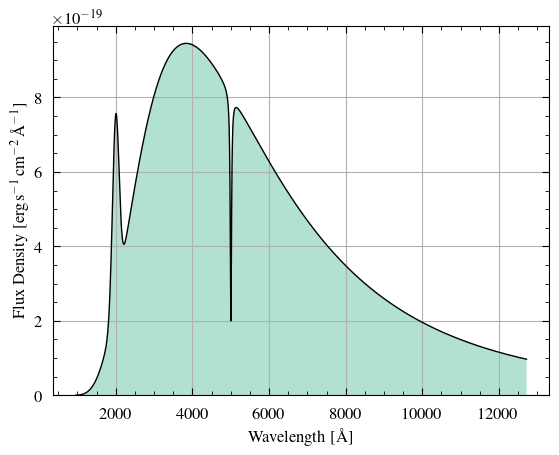

Bolometric AB magnitude: 24.999142761583535
Passband AB magnitudes: {'uv': 26.484461204831213, 'u': 25.009805288085623, 'g': 24.436944919160602}

INFO: Point source encircled energy from supersampling aperture = 74.29%
INFO: Point source encircled energy (analytical result) = 74.30%
INFO: these weights are for visualization purposes only.
      Set the `encircled_energy` parameter in the `calc_snr_or_t()` method to affect the signal-to-noise or integration time calculations.
      You can silence this message by setting `quiet=True`.


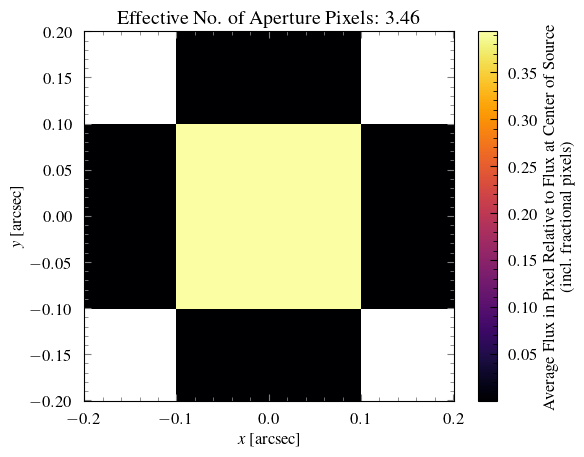

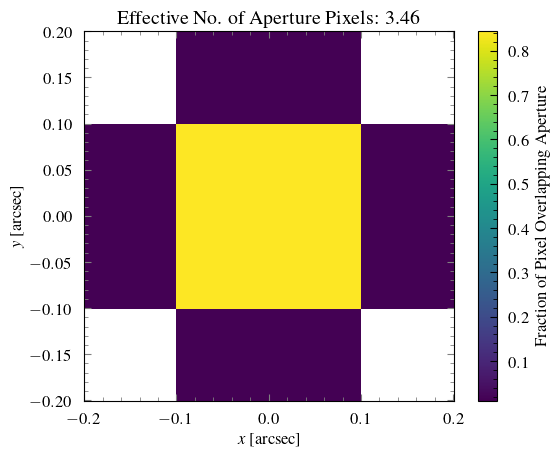

Time (s) required to reach SNR=10 in uv-band 1242.2365716398174
SNR achieved in t=1242.2365716398174 seconds in uv-band 10.0

Time (s) required to reach SNR=10 in u-band 256.3307015936759
SNR achieved in t=256.3307015936759 seconds in u-band 10.0

Time (s) required to reach SNR=10 in g-band 134.29569947846804
SNR achieved in t=134.29569947846804 seconds in g-band 9.999999999999998



In [2]:
# Same as the 1st example in
# [getting_started_photometry.ipynb](https://github.com/CASTOR-telescope/ETC_notebooks/blob/a5357452875033a6e4e28f001d55210871c02cfa/getting_started_photometry.ipynb)

MyTelescope = Telescope()

MyBackground = Background()
MyBackground.add_geocoronal_emission(flux="high")

MySource = PointSource()
MySource.generate_bb(8000 * u.K, redshift=0.06)
MySource.norm_to_AB_mag(25)
MySource.add_emission_line(
    center=2000 * u.AA, fwhm=200 * u.AA, peak=5e-19, shape="gaussian", abs_peak=False
)
MySource.add_absorption_line(
    center=5005 * u.AA, fwhm=40 * u.AA, dip=2e-19, shape="lorentzian", abs_dip=True
)
MySource.show_spectrum()

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_optimal_aperture(factor=1.4, supersample_factor=100)

MyPhot.show_source_weights()
MyPhot.show_aper_weights()

TARGET_SNR = 10
REDDENING = 0.01

for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING)[band]
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()

## Elliptical aperture examples

### Point source with elliptical aperture

We recover the same results as those from the optimal aperture when we set the same
parameters.


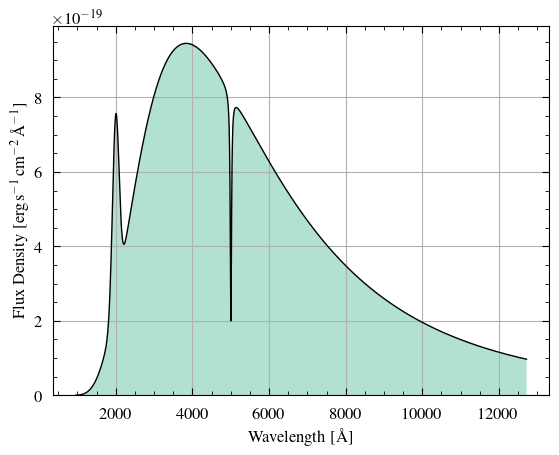

Bolometric AB magnitude: 24.999142761583535
Passband AB magnitudes: {'uv': 26.484461204831213, 'u': 25.009805288085623, 'g': 24.436944919160602}

INFO: Fraction of flux within aperture (estimated via supersampling aperture) = 74.21%
INFO: Point source encircled energy (from MC integration, more exact) = 74.30%
INFO: these weights are for visualization purposes only.
      Set the `encircled_energy` parameter in the `calc_snr_or_t()` method to affect the signal-to-noise or integration time calculations.
      You can silence this message by setting `quiet=True`.


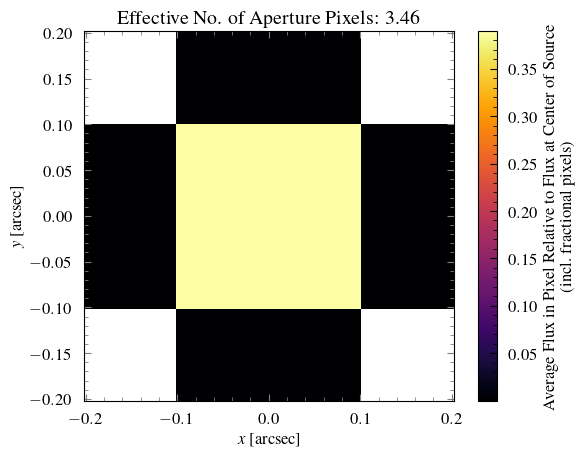

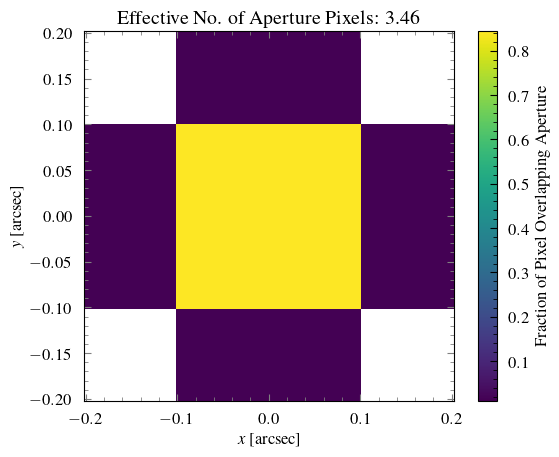

Time (s) required to reach SNR=10 in uv-band 1242.1567016832505
SNR achieved in t=1242.1567016832505 seconds in uv-band 9.999999999999998

Time (s) required to reach SNR=10 in u-band 256.31571419808813
SNR achieved in t=256.31571419808813 seconds in u-band 10.0

Time (s) required to reach SNR=10 in g-band 134.2871911140295
SNR achieved in t=134.2871911140295 seconds in g-band 9.999999999999998



In [3]:
MyTelescope = Telescope()

MyBackground = Background()
MyBackground.add_geocoronal_emission(flux="high")

MySource = PointSource()
MySource.generate_bb(8000 * u.K, redshift=0.06)
MySource.norm_to_AB_mag(25)
MySource.add_emission_line(
    center=2000 * u.AA, fwhm=200 * u.AA, peak=5e-19, shape="gaussian", abs_peak=False
)
MySource.add_absorption_line(
    center=5005 * u.AA, fwhm=40 * u.AA, dip=2e-19, shape="lorentzian", abs_dip=True
)
MySource.show_spectrum()

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
a = b = 1.4 * (MyTelescope.fwhm / 2)
MyPhot.use_elliptical_aperture(a=a, b=b, supersample_factor=20, center=[0, 0] * u.arcsec)

MyPhot.show_source_weights()
MyPhot.show_aper_weights()

TARGET_SNR = 10
REDDENING = 0.01

for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING)[band]
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()

Now an off-centred elliptical aperture for a point source.


Bolometric AB magnitude: 24.999142761583535
Passband AB magnitudes: {'uv': 26.484461204831213, 'u': 25.009805288085623, 'g': 24.436944919160602}

INFO: Fraction of flux within aperture (estimated via supersampling aperture) = 63.82%
INFO: Point source encircled energy (from MC integration, more exact) = 63.70%
INFO: these weights are for visualization purposes only.
      Set the `encircled_energy` parameter in the `calc_snr_or_t()` method to affect the signal-to-noise or integration time calculations.
      You can silence this message by setting `quiet=True`.


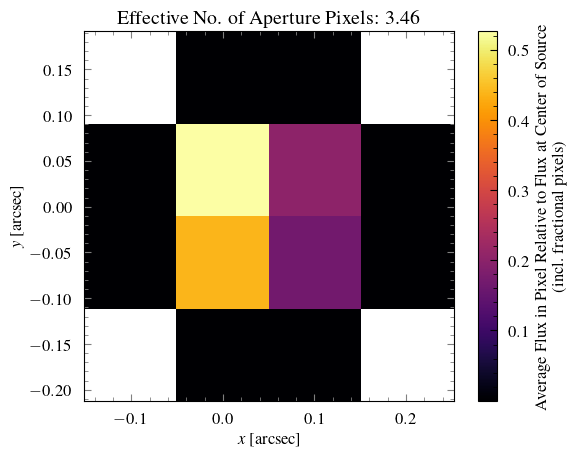

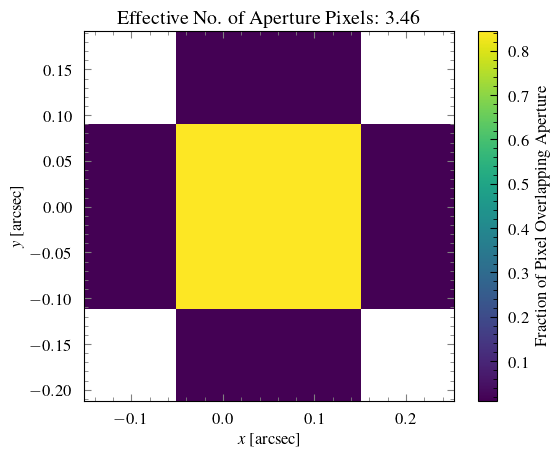

Time (s) required to reach SNR=10 in uv-band 1489.1584118731435
SNR achieved in t=1489.1584118731435 seconds in uv-band 10.0

Time (s) required to reach SNR=10 in u-band 302.0083546923567
SNR achieved in t=302.0083546923567 seconds in u-band 10.000000000000002

Time (s) required to reach SNR=10 in g-band 160.5439651978808
SNR achieved in t=160.5439651978808 seconds in g-band 10.000000000000004



In [4]:
MyTelescope = Telescope()

MyBackground = Background()
MyBackground.add_geocoronal_emission(flux="high")

MySource = PointSource()
MySource.generate_bb(8000 * u.K, redshift=0.06)
MySource.norm_to_AB_mag(25)
MySource.add_emission_line(
    center=2000 * u.AA, fwhm=200 * u.AA, peak=5e-19, shape="gaussian", abs_peak=False
)
MySource.add_absorption_line(
    center=5005 * u.AA, fwhm=40 * u.AA, dip=2e-19, shape="lorentzian", abs_dip=True
)

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
a = b = 1.4 * (MyTelescope.fwhm / 2)
MyPhot.use_elliptical_aperture(
    a=a, b=b, supersample_factor=20, center=[0.05, -0.01] * u.arcsec
)

MyPhot.show_source_weights()
MyPhot.show_aper_weights()

TARGET_SNR = 10
REDDENING = 0.01

for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING)[band]
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()

### Galaxy source with elliptical aperture

Below, we see an aperture the size of the half light radius enclosing half the light from
the galaxy, as expected.

Also notice the galaxy with a de Vaucouleurs profile (n=4) is no longer just a single
bright pixel!

Finally, take a look at the SNR calculation results.

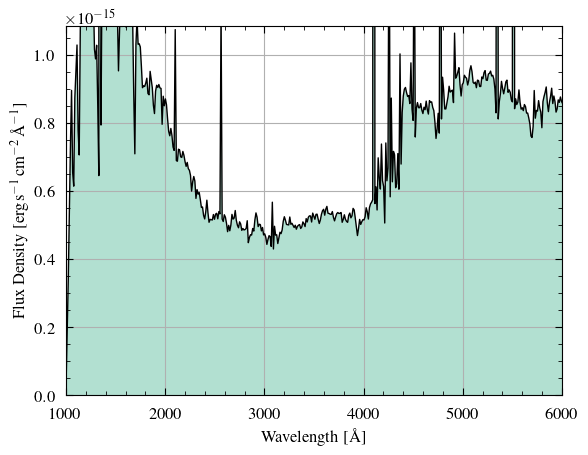

Bolometric AB magnitude: 16.458904724098822
Passband AB magnitudes: {'uv': 18.76106637720853, 'u': 18.136436380681552, 'g': 16.678916334742347}

INFO: Fraction of flux within aperture (estimated via supersampling aperture) = 50.00%
INFO: these weights are for visualization purposes only.
      Set the `encircled_energy` parameter in the `calc_snr_or_t()` method to affect the signal-to-noise or integration time calculations.
      You can silence this message by setting `quiet=True`.


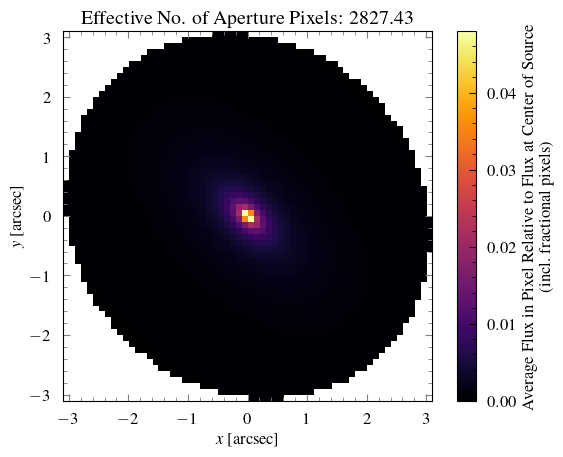

INFO: these weights are for visualization purposes only.
      Set the `encircled_energy` parameter in the `calc_snr_or_t()` method to affect the signal-to-noise or integration time calculations.
      You can silence this message by setting `quiet=True`.


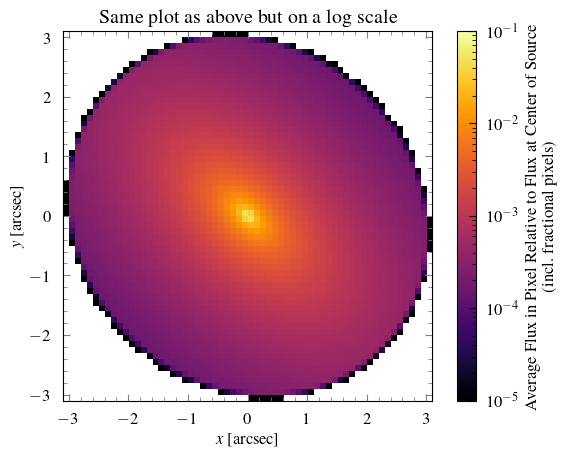

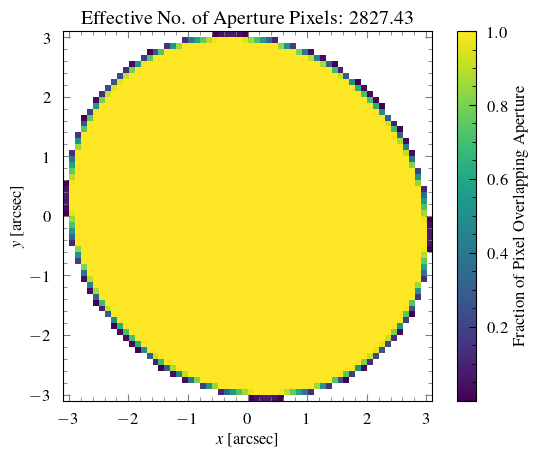

SNR achieved in t=4321 seconds in uv-band 585.7729342590507
Time (s) required to reach SNR=585.7729342590507 in uv-band 4321.0

SNR achieved in t=4321 seconds in u-band 793.8313360647036
Time (s) required to reach SNR=793.8313360647036 in u-band 4321.0

SNR achieved in t=4321 seconds in g-band 1711.872334731051
Time (s) required to reach SNR=1711.872334731051 in g-band 4321.000000000002



In [5]:
MyTelescope = Telescope()

MyBackground = Background()
MyBackground.add_geocoronal_emission(
    flux=1e-15, wavelength=2345 * u.AA, linewidth=0.023 * u.AA
)

MySource = GalaxySource(r_eff=3 * u.arcsec, n=4, axial_ratio=0.9, rotation=135)

MySource.use_galaxy_spectrum(gal_type="spiral")
MySource.norm_luminosity_dist(luminosity=1.4e9, dist=58.3 * u.Mpc)
MySource.redshift_wavelengths(0.1)
fig, ax = MySource.show_spectrum(plot=False)
ax.set_xlim(1000, 6000)
ax.set_ylim(top=np.percentile(MySource.spectrum, 96))
plt.show()

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()


MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_elliptical_aperture(
    a=MySource.angle_a,
    b=MySource.angle_b,
    center=[0, 0] * u.arcsec,
    rotation=np.rad2deg(MySource.rotation),
)

MyPhot.show_source_weights()
fig, ax, cbar = MyPhot.show_source_weights(norm=LogNorm(vmin=1e-5, vmax=0.1), plot=False)
ax.set_title("Same plot as above but on a log scale")
plt.show()
MyPhot.show_aper_weights()

INTEGRATION_TIME = 4321
REDDENING = 0.01

for band in MyTelescope.passbands:
    snr = MyPhot.calc_snr_or_t(t=INTEGRATION_TIME, reddening=REDDENING)[band]
    print(f"SNR achieved in t={INTEGRATION_TIME} seconds in {band}-band", snr)
    time = MyPhot.calc_snr_or_t(snr=snr, reddening=REDDENING)[band]
    print(f"Time (s) required to reach SNR={snr} in {band}-band", time)
    print()

Now we move the aperture off centre and increase its eccentricity. You can see what
happens when you change the supersampling factor

Bolometric AB magnitude: 16.458904724098822
Passband AB magnitudes: {'uv': 18.76106637720853, 'u': 18.136436380681552, 'g': 16.678916334742347}

INFO: Fraction of flux within aperture (estimated via supersampling aperture) = 27.81%
INFO: these weights are for visualization purposes only.
      Set the `encircled_energy` parameter in the `calc_snr_or_t()` method to affect the signal-to-noise or integration time calculations.
      You can silence this message by setting `quiet=True`.


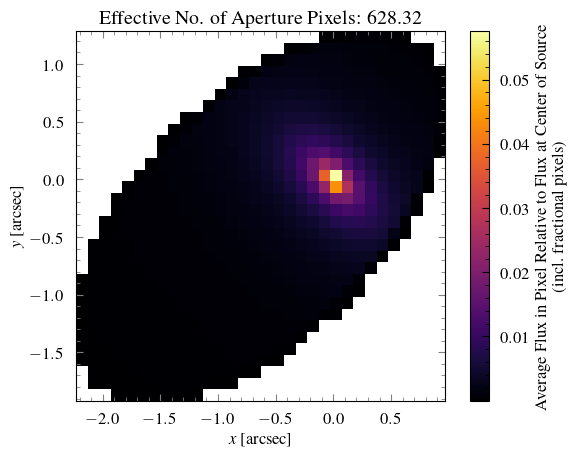

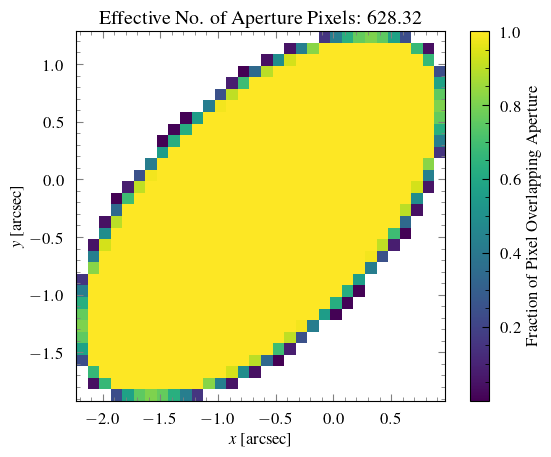

SNR achieved in t=4321 seconds in uv-band 454.45772605447246
Time (s) required to reach SNR=454.45772605447246 in uv-band 4321.000000000002

SNR achieved in t=4321 seconds in u-band 628.3557337477736
Time (s) required to reach SNR=628.3557337477736 in u-band 4321.0

SNR achieved in t=4321 seconds in g-band 1363.141370646213
Time (s) required to reach SNR=1363.141370646213 in g-band 4321.0



In [6]:
MyTelescope = Telescope()

MyBackground = Background()
MyBackground.add_geocoronal_emission(
    flux=1e-15, wavelength=2345 * u.AA, linewidth=0.023 * u.AA
)

MySource = GalaxySource(r_eff=3 * u.arcsec, n=4, axial_ratio=0.9, rotation=135)

MySource.use_galaxy_spectrum(gal_type="spiral")
MySource.norm_luminosity_dist(luminosity=1.4e9, dist=58.3 * u.Mpc)
MySource.redshift_wavelengths(0.1)

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()


MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_elliptical_aperture(
    2 * u.arcsec,
    1 * u.arcsec,
    center=np.array([-0.2, -0.1]) * MySource.angle_a,
    rotation=45,
    # Change me to see what happens. The encircled energy should converge to ~27.82%
    supersample_factor=20,  # 20 is default
)

MyPhot.show_source_weights()
MyPhot.show_aper_weights()

INTEGRATION_TIME = 4321
REDDENING = 0.01

for band in MyTelescope.passbands:
    snr = MyPhot.calc_snr_or_t(t=INTEGRATION_TIME, reddening=REDDENING)[band]
    print(f"SNR achieved in t={INTEGRATION_TIME} seconds in {band}-band", snr)
    time = MyPhot.calc_snr_or_t(snr=snr, reddening=REDDENING)[band]
    print(f"Time (s) required to reach SNR={snr} in {band}-band", time)
    print()

### Extended source with elliptical aperture

We see an aperture with the same extent as an extended source encloses 100% of its flux
(per our definition)

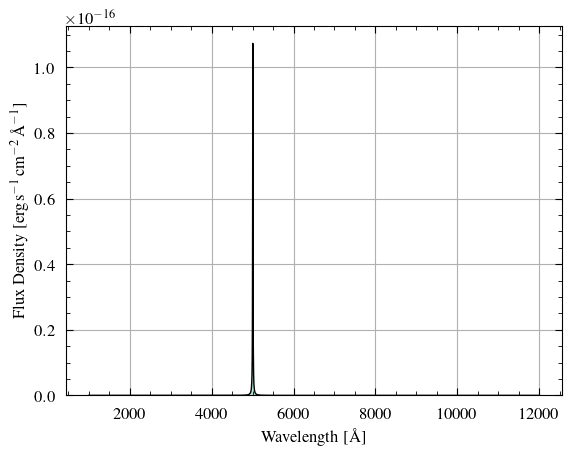

Bolometric AB magnitude: 26.2721435361674
Passband AB magnitudes: {'uv': 31.463107529100533, 'u': 39.00305848994173, 'g': 24.000000000000007}



/arc/home/IsaacCheng/CASTOR/ETC/castor_etc/photometry.py:1197: UserWarning: The ExtendedSource calculation assumes 100% of the flux is contained within the size defined in the ExtendedSource (i.e., by angle_a and angle_b).
  warnings.warn(


INFO: Fraction of flux within aperture (estimated via supersampling aperture) = 100.00%
INFO: these weights are for visualization purposes only.
      Set the `encircled_energy` parameter in the `calc_snr_or_t()` method to affect the signal-to-noise or integration time calculations.
      You can silence this message by setting `quiet=True`.


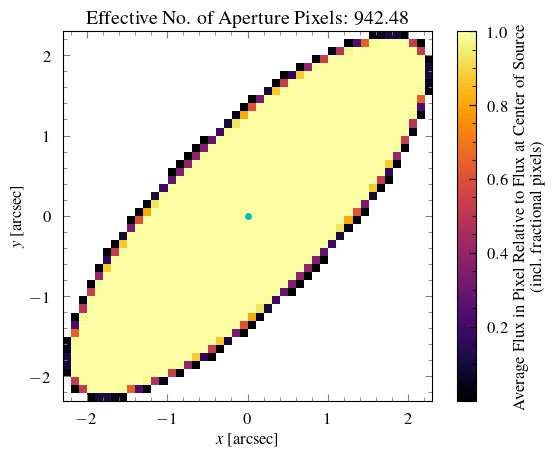

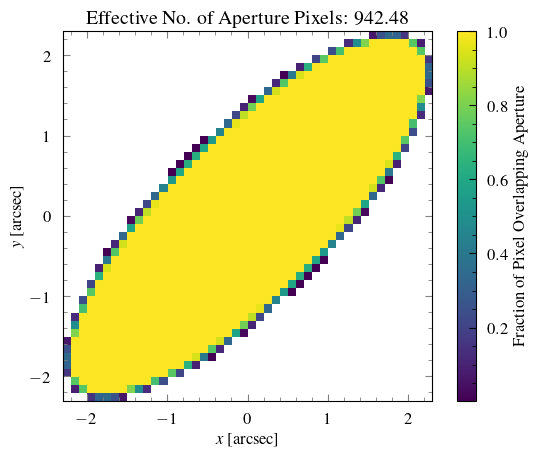

Time (s) required to reach SNR=10 in uv-band 437224330.89251447
SNR achieved in t=437224330.89251447 seconds in uv-band 10.000000000000002

Time (s) required to reach SNR=10 in u-band 1026762990934386.9
SNR achieved in t=1026762990934386.9 seconds in u-band 10.0

Time (s) required to reach SNR=10 in g-band 1926.5213644643889
SNR achieved in t=1926.5213644643889 seconds in g-band 10.0



In [7]:
MyTelescope = Telescope(dark_current=0.01)

MyBackground = Background(mags_per_sq_arcsec={"uv": 26.08, "u": 23.74, "g": 22.60})
MySource = ExtendedSource(
    angle_a=3 * u.arcsec, angle_b=1 * u.arcsec, rotation=45, profile="uniform"
)

MySource.generate_emission_line(
    center=5007 * u.AA, fwhm=10 * u.AA, peak=7e-21, shape="lorentzian"
)
MySource.norm_to_AB_mag(24, "g", TelescopeObj=MyTelescope)
MySource.show_spectrum()

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_elliptical_aperture(a=3 * u.arcsec, b=1 * u.arcsec, rotation=45)

MyPhot.show_source_weights(mark_source=True)
MyPhot.show_aper_weights()

TARGET_SNR = 10
REDDENING = 0

for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING)[band]
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()

If we increase the size of the aperture but keep the entire source enclosed, the fraction
of flux within the aperture is still 100% but not the time required to reach our target
SNR increases because there are many more background pixels.

Keep in mind the user can change the value of the encircled energy (the fraction of the
flux contained within the aperture) for the photometry calculations. This is done simply
via the `encircled_energy` parameter in
`<PhotometryObj>.calc_snr_or_t(encircled_energy=<num>)`

Bolometric AB magnitude: 26.2721435361674
Passband AB magnitudes: {'uv': 31.463107529100533, 'u': 39.00305848994173, 'g': 24.000000000000007}



/arc/home/IsaacCheng/CASTOR/ETC/castor_etc/photometry.py:1197: UserWarning: The ExtendedSource calculation assumes 100% of the flux is contained within the size defined in the ExtendedSource (i.e., by angle_a and angle_b).
  warnings.warn(


INFO: Fraction of flux within aperture (estimated via supersampling aperture) = 100.09%
INFO: these weights are for visualization purposes only.
      Set the `encircled_energy` parameter in the `calc_snr_or_t()` method to affect the signal-to-noise or integration time calculations.
      You can silence this message by setting `quiet=True`.


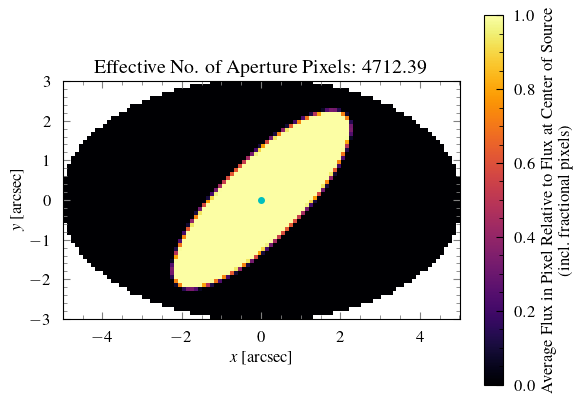

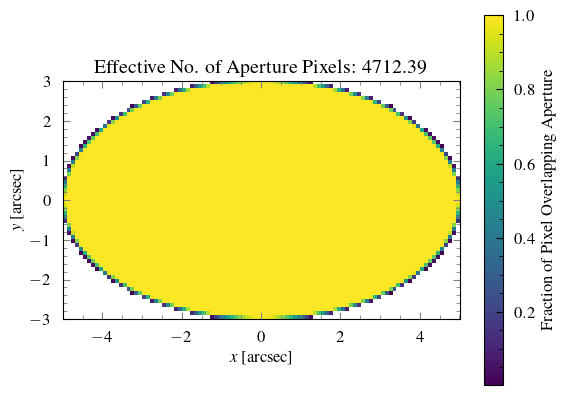

Time (s) required to reach SNR=10 in uv-band 2216052993.6550064
SNR achieved in t=2216052993.6550064 seconds in uv-band 9.999999999999998

Time (s) required to reach SNR=10 in u-band 5204701952931940.0
SNR achieved in t=5204701952931940.0 seconds in u-band 10.0

Time (s) required to reach SNR=10 in g-band 9383.174065955182
SNR achieved in t=9383.174065955182 seconds in g-band 10.0



In [8]:
MyTelescope = Telescope(dark_current=0.01)

MyBackground = Background(mags_per_sq_arcsec={"uv": 26.08, "u": 23.74, "g": 22.60})
MySource = ExtendedSource(
    angle_a=3 * u.arcsec, angle_b=1 * u.arcsec, rotation=45, profile="uniform"
)

MySource.generate_emission_line(
    center=5007 * u.AA, fwhm=10 * u.AA, peak=7e-21, shape="lorentzian"
)
MySource.norm_to_AB_mag(24, "g", TelescopeObj=MyTelescope)

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_elliptical_aperture(a=5 * u.arcsec, b=3 * u.arcsec, rotation=0)

MyPhot.show_source_weights(mark_source=True)
MyPhot.show_aper_weights()

TARGET_SNR = 10
REDDENING = 0

for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING)[band]
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()

We can also create an off-centre aperture that is oriented perpendicular to the source
because we are bad astronomers

Bolometric AB magnitude: 26.2721435361674
Passband AB magnitudes: {'uv': 31.463107529100533, 'u': 39.00305848994173, 'g': 24.000000000000007}



/arc/home/IsaacCheng/CASTOR/ETC/castor_etc/photometry.py:1197: UserWarning: The ExtendedSource calculation assumes 100% of the flux is contained within the size defined in the ExtendedSource (i.e., by angle_a and angle_b).
  warnings.warn(


INFO: Fraction of flux within aperture (estimated via supersampling aperture) = 30.30%
INFO: these weights are for visualization purposes only.
      Set the `encircled_energy` parameter in the `calc_snr_or_t()` method to affect the signal-to-noise or integration time calculations.
      You can silence this message by setting `quiet=True`.


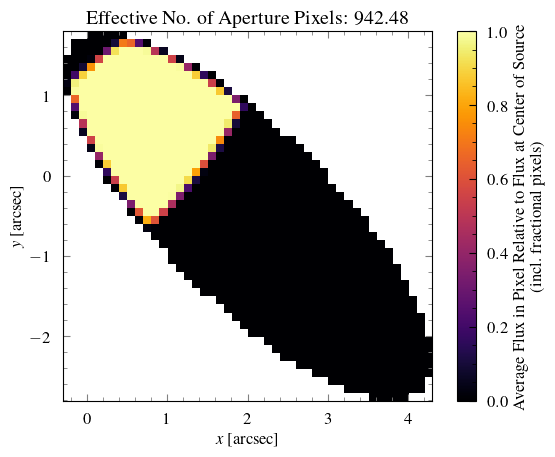

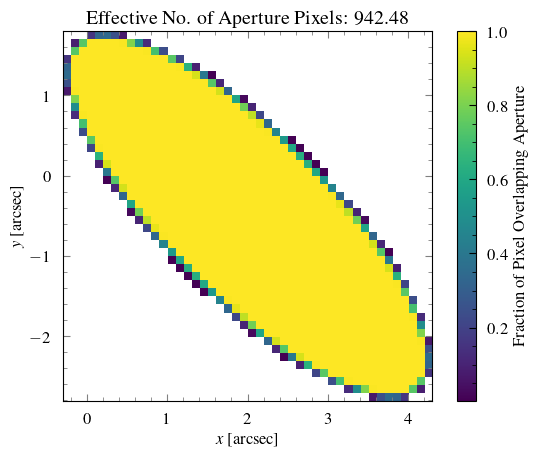

Time (s) required to reach SNR=10 in uv-band 4760782447.052425
SNR achieved in t=4760782447.052425 seconds in uv-band 10.0

Time (s) required to reach SNR=10 in u-band 1.1181177766375582e+16
SNR achieved in t=1.1181177766375582e+16 seconds in u-band 10.0

Time (s) required to reach SNR=10 in g-band 20160.36009192632
SNR achieved in t=20160.36009192632 seconds in g-band 10.0



In [9]:
MyTelescope = Telescope(dark_current=0.01)

MyBackground = Background(mags_per_sq_arcsec={"uv": 26.08, "u": 23.74, "g": 22.60})
MySource = ExtendedSource(
    angle_a=3 * u.arcsec, angle_b=1 * u.arcsec, rotation=45, profile="uniform"
)

MySource.generate_emission_line(
    center=5007 * u.AA, fwhm=10 * u.AA, peak=7e-21, shape="lorentzian"
)
MySource.norm_to_AB_mag(24, "g", TelescopeObj=MyTelescope)

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_elliptical_aperture(
    a=3 * u.arcsec, b=1 * u.arcsec, rotation=135, center=[2, -0.5] * u.arcsec
)

MyPhot.show_source_weights()
MyPhot.show_aper_weights()

TARGET_SNR = 10
REDDENING = 0

for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING)[band]
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()

## Rectangular aperture examples

### Point source with rectangular aperture

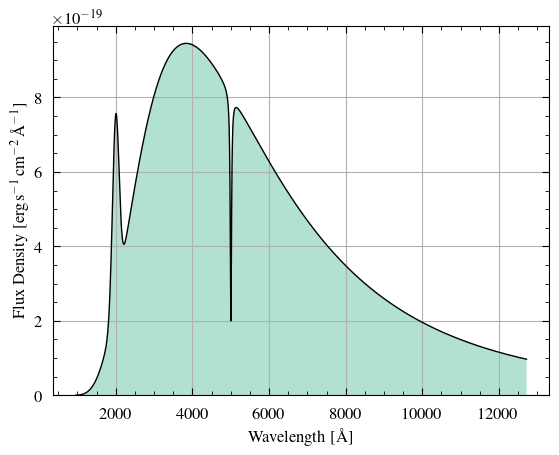

Bolometric AB magnitude: 24.999142761583535
Passband AB magnitudes: {'uv': 26.484461204831213, 'u': 25.009805288085623, 'g': 24.436944919160602}

INFO: Fraction of flux within aperture (estimated via supersampling aperture) = 99.75%
INFO: Point source encircled energy (from MC integration, more exact) = 100.00%
INFO: these weights are for visualization purposes only.
      Set the `encircled_energy` parameter in the `calc_snr_or_t()` method to affect the signal-to-noise or integration time calculations.
      You can silence this message by setting `quiet=True`.


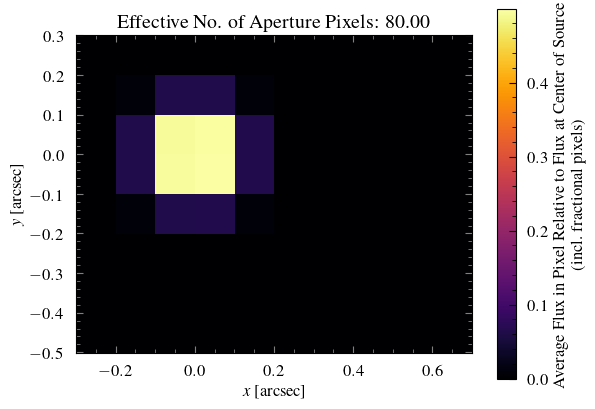

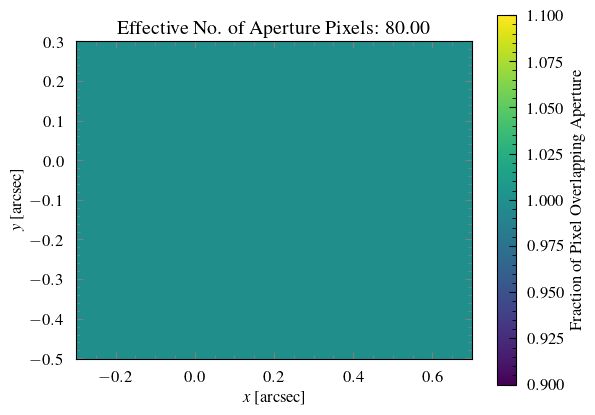

Time (s) required to reach SNR=10 in uv-band 4478.75061266715
SNR achieved in t=4478.75061266715 seconds in uv-band 9.999999999999998

Time (s) required to reach SNR=10 in u-band 563.7685193821706
SNR achieved in t=563.7685193821706 seconds in u-band 9.999999999999996

Time (s) required to reach SNR=10 in g-band 452.240322220236
SNR achieved in t=452.240322220236 seconds in g-band 10.000000000000004



In [10]:
MyTelescope = Telescope()

MyBackground = Background()
MyBackground.add_geocoronal_emission(flux="high")

MySource = PointSource()
MySource.generate_bb(8000 * u.K, redshift=0.06)
MySource.norm_to_AB_mag(25)
MySource.add_emission_line(
    center=2000 * u.AA, fwhm=200 * u.AA, peak=5e-19, shape="gaussian", abs_peak=False
)
MySource.add_absorption_line(
    center=5005 * u.AA, fwhm=40 * u.AA, dip=2e-19, shape="lorentzian", abs_dip=True
)
MySource.show_spectrum()

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_rectangular_aperture(
    width=1 * u.arcsec,
    length=0.8 * u.arcsec,
    center=[0.2, -0.1] * u.arcsec,
    supersample_factor=50,
)

MyPhot.show_source_weights()
MyPhot.show_aper_weights()

TARGET_SNR = 10
REDDENING = 0.01

for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING)[band]
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()

### Galaxy source with rectangular aperture

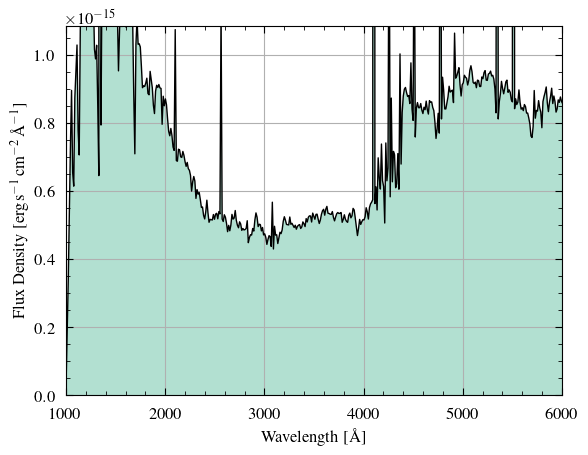

Bolometric AB magnitude: 16.458904724098822
Passband AB magnitudes: {'uv': 18.76106637720853, 'u': 18.136436380681552, 'g': 16.678916334742347}

INFO: Fraction of flux within aperture (estimated via supersampling aperture) = 36.67%
INFO: these weights are for visualization purposes only.
      Set the `encircled_energy` parameter in the `calc_snr_or_t()` method to affect the signal-to-noise or integration time calculations.
      You can silence this message by setting `quiet=True`.


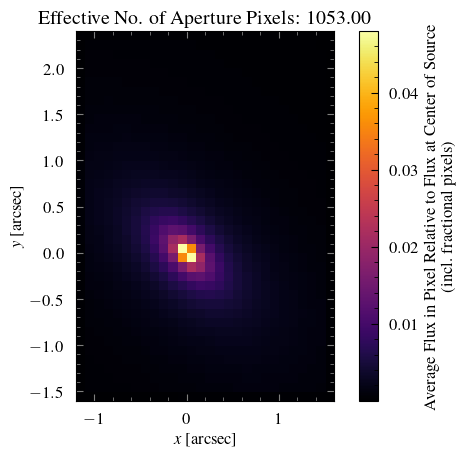

INFO: these weights are for visualization purposes only.
      Set the `encircled_energy` parameter in the `calc_snr_or_t()` method to affect the signal-to-noise or integration time calculations.
      You can silence this message by setting `quiet=True`.


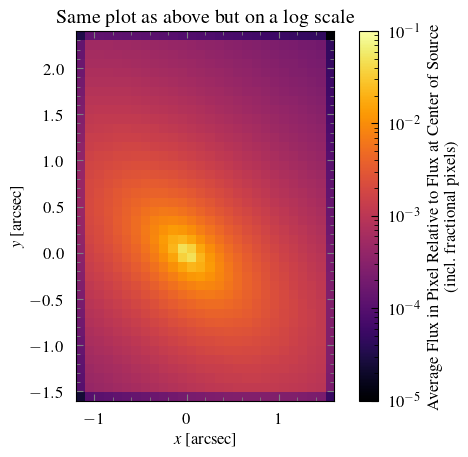

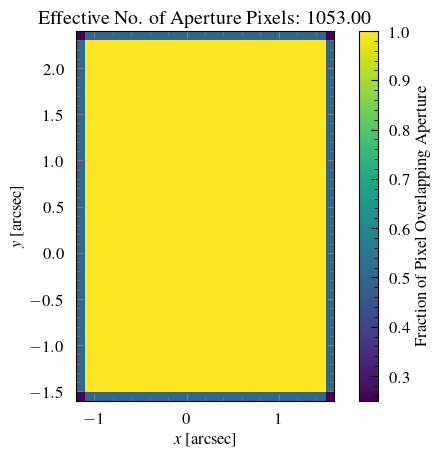

SNR achieved in t=4321 seconds in uv-band 518.1623034716777
Time (s) required to reach SNR=518.1623034716777 in uv-band 4321.000000000001

SNR achieved in t=4321 seconds in u-band 713.7871372181208
Time (s) required to reach SNR=713.7871372181208 in u-band 4320.999999999999

SNR achieved in t=4321 seconds in g-band 1546.7548853171882
Time (s) required to reach SNR=1546.7548853171882 in g-band 4321.000000000001



In [11]:
MyTelescope = Telescope()

MyBackground = Background()
MyBackground.add_geocoronal_emission(
    flux=1e-15, wavelength=2345 * u.AA, linewidth=0.023 * u.AA
)

MySource = GalaxySource(r_eff=3 * u.arcsec, n=4, axial_ratio=0.9, rotation=135)

MySource.use_galaxy_spectrum(gal_type="spiral")
MySource.norm_luminosity_dist(luminosity=1.4e9, dist=58.3 * u.Mpc)
MySource.redshift_wavelengths(0.1)
fig, ax = MySource.show_spectrum(plot=False)
ax.set_xlim(1000, 6000)
ax.set_ylim(top=np.percentile(MySource.spectrum, 96))
plt.show()

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()


MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_rectangular_aperture(
    width=2.7 * u.arcsec,
    length=3.9 * u.arcsec,
    center=[0.2, 0.4] * u.arcsec,
    supersample_factor=50,
)

MyPhot.show_source_weights()
fig, ax, cbar = MyPhot.show_source_weights(norm=LogNorm(vmin=1e-5, vmax=0.1), plot=False)
ax.set_title("Same plot as above but on a log scale")
plt.show()
MyPhot.show_aper_weights()

INTEGRATION_TIME = 4321
REDDENING = 0.01

for band in MyTelescope.passbands:
    snr = MyPhot.calc_snr_or_t(t=INTEGRATION_TIME, reddening=REDDENING)[band]
    print(f"SNR achieved in t={INTEGRATION_TIME} seconds in {band}-band", snr)
    time = MyPhot.calc_snr_or_t(snr=snr, reddening=REDDENING)[band]
    print(f"Time (s) required to reach SNR={snr} in {band}-band", time)
    print()

### Extended source with rectangular aperture

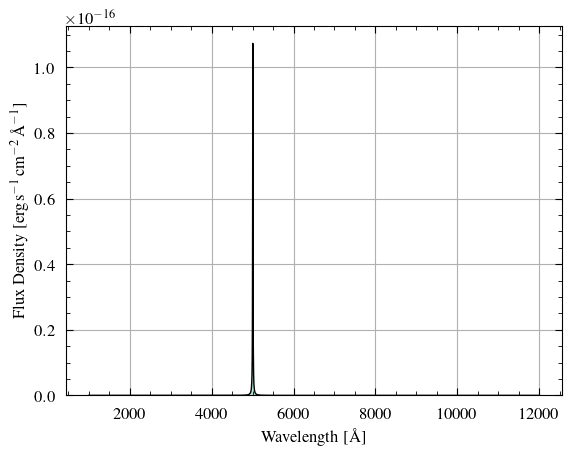

Bolometric AB magnitude: 26.2721435361674
Passband AB magnitudes: {'uv': 31.463107529100533, 'u': 39.00305848994173, 'g': 24.000000000000007}



/arc/home/IsaacCheng/CASTOR/ETC/castor_etc/photometry.py:1500: UserWarning: The ExtendedSource calculation assumes 100% of the flux is contained within the size defined in the ExtendedSource (i.e., by angle_a and angle_b).
  warnings.warn(


INFO: Fraction of flux within aperture (estimated via supersampling aperture) = 53.95%
INFO: these weights are for visualization purposes only.
      Set the `encircled_energy` parameter in the `calc_snr_or_t()` method to affect the signal-to-noise or integration time calculations.
      You can silence this message by setting `quiet=True`.


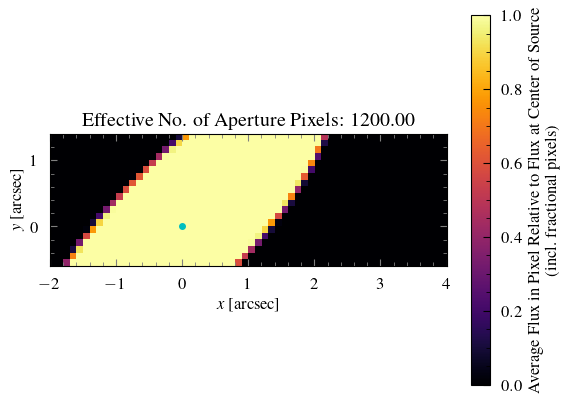

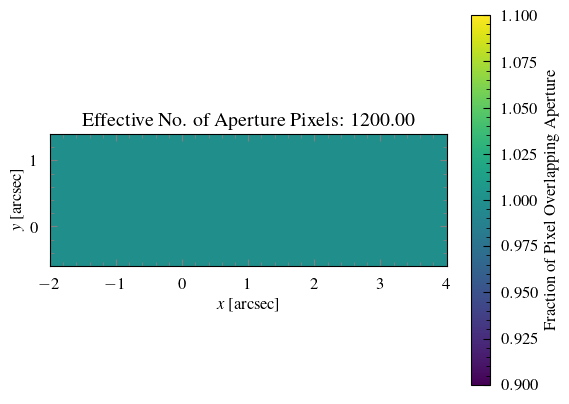

Time (s) required to reach SNR=10 in uv-band 1959144638.1342118
SNR achieved in t=1959144638.1342118 seconds in uv-band 9.999999999999998

Time (s) required to reach SNR=10 in u-band 4601175987412832.0
SNR achieved in t=4601175987412832.0 seconds in u-band 10.0

Time (s) required to reach SNR=10 in g-band 8346.838614346658
SNR achieved in t=8346.838614346658 seconds in g-band 10.0



In [12]:
MyTelescope = Telescope(dark_current=0.01)

MyBackground = Background(mags_per_sq_arcsec={"uv": 26.08, "u": 23.74, "g": 22.60})
MySource = ExtendedSource(
    angle_a=3 * u.arcsec, angle_b=1 * u.arcsec, rotation=45, profile="uniform"
)

MySource.generate_emission_line(
    center=5007 * u.AA, fwhm=10 * u.AA, peak=7e-21, shape="lorentzian"
)
MySource.norm_to_AB_mag(24, "g", TelescopeObj=MyTelescope)
MySource.show_spectrum()

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_rectangular_aperture(
    width=6 * u.arcsec,
    length=2 * u.arcsec,
    center=[1, 0.4] * u.arcsec,
    supersample_factor=50,
)

MyPhot.show_source_weights(mark_source=True)
MyPhot.show_aper_weights()

TARGET_SNR = 10
REDDENING = 0

for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING)[band]
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()